In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller


In [2]:
df = pd.read_csv('dataset - dataset.csv')
df

,order_id,product_id,price,count,profit_per_item,status,is_rental,date_confirm
0,0,0,24.34,1,14.44,Returned,1,2023-08-02
1,0,4,23.98,1,-1.16,Returned,1,2023-08-02
2,0,5,13.30,1,3.40,Shipped,0,2023-08-02
3,2932,3526,33.23,1,6.60,Shipped,0,2023-08-03
4,4154,5117,115.37,1,27.89,Shipped,0,2023-08-01
...,...,...,...,...,...,...,...,...
116337,1577958,2009389,42.49,1,17.18,Shipped,0,2024-07-31
116338,1577958,2009390,83.53,1,34.64,Shipped,0,2024-07-31
116339,1577977,2009407,12.82,1,3.66,Shipped,0,2024-07-31
116340,1515253,2019280,16.28,1,-3.96,Returned,0,2024-07-17


In [3]:
for column in df:
    unique_vals = np.unique(df[column])
    nr_values = len(unique_vals)
    if nr_values < 12:
        print('Количество значений {} :{} -- {}'.format(column, nr_values,unique_vals))
    else:
        print('Количество значений {} :{}'.format(column, nr_values))

Количество значений order_id :104183
Количество значений product_id :116342
Количество значений price :12008
Количество значений count :18
Количество значений profit_per_item :15017
Количество значений status :2 -- ['Returned' 'Shipped']
Количество значений is_rental :2 -- [0 1]
Количество значений date_confirm :366


In [4]:
df.isnull().sum()

order_id           0
product_id         0
price              0
count              0
profit_per_item    0
status             0
is_rental          0
date_confirm       0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116342 entries, 0 to 116341
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   order_id         116342 non-null  int64  
 1   product_id       116342 non-null  int64  
 2   price            116342 non-null  float64
 3   count            116342 non-null  int64  
 4   profit_per_item  116342 non-null  float64
 5   status           116342 non-null  object 
 6   is_rental        116342 non-null  int64  
 7   date_confirm     116342 non-null  object 
dtypes: float64(2), int64(4), object(2)
memory usage: 7.1+ MB


In [6]:
df['date_confirm'] = pd.to_datetime(df['date_confirm'])
df['month'] = df['date_confirm'].dt.month
df['year'] = df['date_confirm'].dt.year
df['day_of_week'] = df['date_confirm'].dt.dayofweek 

In [7]:
print('Min data:', df['date_confirm'].min()) 
print('Max data:', df['date_confirm'].max())
print('Diff days:', df['date_confirm'].max() - df['date_confirm'].min())

Min data: 2023-08-01 00:00:00
Max data: 2024-07-31 00:00:00
Diff days: 365 days 00:00:00


In [8]:
status_summary = df.groupby('status').agg({
    'price': 'sum',
    'count': 'sum',
    'profit_per_item': 'sum'
})
status_summary['total_profit'] = status_summary['profit_per_item'] * status_summary['count']
status_summary

,price,count,profit_per_item,total_profit
status,,,,
Returned,1234943.84,34822,513188.25,1.787024e+10
Shipped,3390442.20,84285,1356141.94,1.143024e+11


In [9]:
df.dtypes

order_id                    int64
product_id                  int64
price                     float64
count                       int64
profit_per_item           float64
status                     object
is_rental                   int64
date_confirm       datetime64[ns]
month                       int32
year                        int32
day_of_week                 int32
dtype: object

In [10]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
data_new = df['status']
df['status'] = labelencoder.fit_transform(data_new.values)

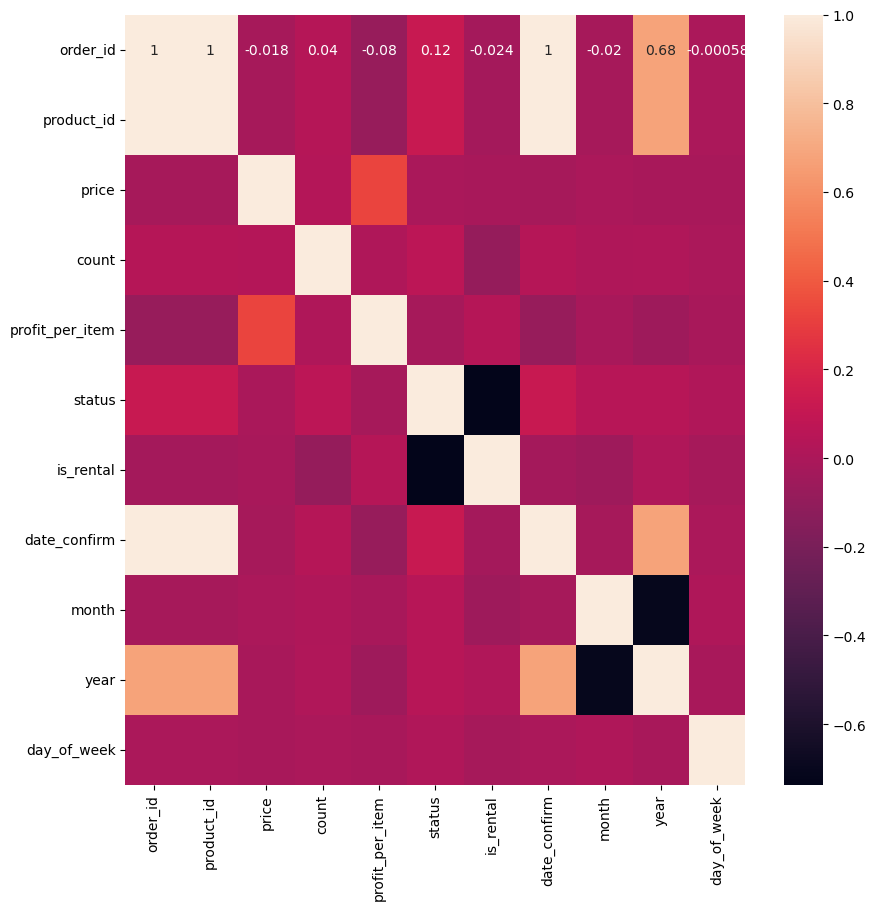

In [11]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df.corr(method='kendall'),annot=True);

In [12]:
df['is_weekend'] = df['date_confirm'].dt.weekday >= 5

In [13]:
df['total_profit'] = df['count'] * df['profit_per_item']
profit_by_product = df.groupby('product_id')['total_profit'].sum().reset_index()
profit_by_product

,product_id,total_profit
0,0,14.44
1,4,-1.16
2,5,3.40
3,3526,6.60
4,5117,27.89
...,...,...
116337,2009389,17.18
116338,2009390,34.64
116339,2009407,3.66
116340,2019280,-3.96


## Анализ связи отрицательной прибыли с возвратом

In [14]:
negative_profit_df = df[df['profit_per_item'] < 0]
returns_df = df[df['status'] == 0 ]

profit_summary = negative_profit_df.groupby('status')['profit_per_item'].agg(['count', 'sum']).reset_index()
profit_summary.columns = ['status', 'count_negative_profit', 'total_negative_profit']

profit_summary

,status,count_negative_profit,total_negative_profit
0,0,7454,-84028.99
1,1,8190,-152218.80


In [15]:
# Анализ товаров с возвратами
returns_by_product = returns_df.groupby('product_id').agg({
    'count': 'sum',
    'profit_per_item': 'sum'
}).reset_index()
returns_by_product.columns = ['product_id', 'count_returns', 'total_return_profit']
negative_profit_by_product = negative_profit_df.groupby('product_id').agg({
    'count': 'sum',
    'profit_per_item': 'sum'
}).reset_index()
negative_profit_by_product.columns = ['product_id', 'count_negative_profit', 'total_negative_profit']
product_analysis = pd.merge(returns_by_product, negative_profit_by_product, on='product_id', how='outer')
product_analysis.fillna(0, inplace=True)

In [16]:
status_groups = df.groupby('status')
total_items_by_status = status_groups['product_id'].nunique().reset_index()
total_items_by_status.columns = ['status', 'total_products']

negative_items_by_status = negative_profit_df.groupby('status')['product_id'].nunique().reset_index()
negative_items_by_status.columns = ['status', 'negative_profit_products']

In [17]:
status_analysis = pd.merge(total_items_by_status, negative_items_by_status, on='status', how='left')
status_analysis['negative_profit_products'].fillna(0, inplace=True)
status_analysis['percent_negative_profit'] = (status_analysis['negative_profit_products'] / status_analysis['total_products']) * 100
status_analysis['percent_positive_profit'] = 100 - status_analysis['percent_negative_profit']

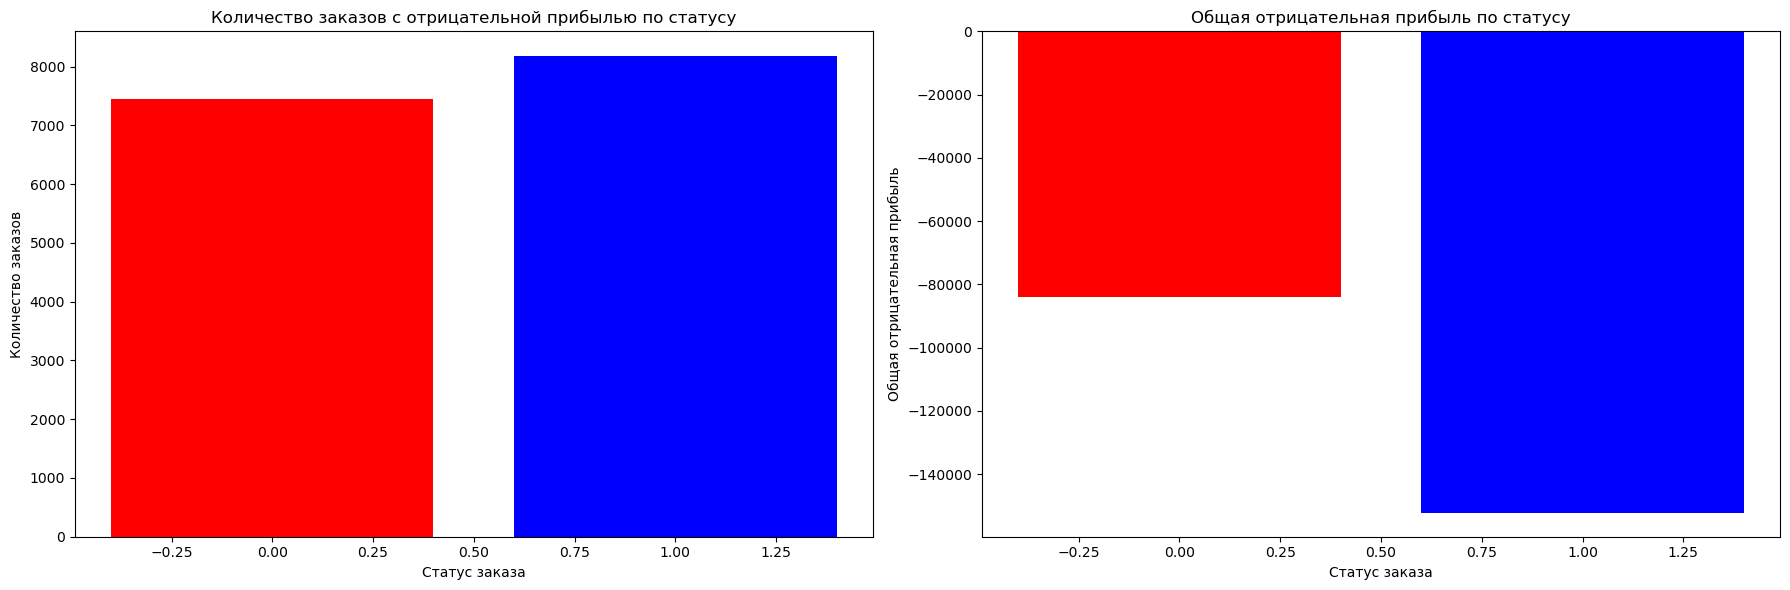

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

ax[0].bar(profit_summary['status'], profit_summary['count_negative_profit'], color=['red', 'blue'])
ax[0].set_title('Количество заказов с отрицательной прибылью по статусу')
ax[0].set_xlabel('Статус заказа')
ax[0].set_ylabel('Количество заказов')

ax[1].bar(profit_summary['status'], profit_summary['total_negative_profit'], color=['red', 'blue'])
ax[1].set_title('Общая отрицательная прибыль по статусу')
ax[1].set_xlabel('Статус заказа')
ax[1].set_ylabel('Общая отрицательная прибыль')

plt.tight_layout()
plt.show()

Заказы, которые были отправлены, кажутся более проблематичными с точки зрения прибыли, чем возвращённые заказы. Это может указывать на высокие расходы на обработку или логистику, низкую цену продажи по сравнению с затратами или другие проблемы.



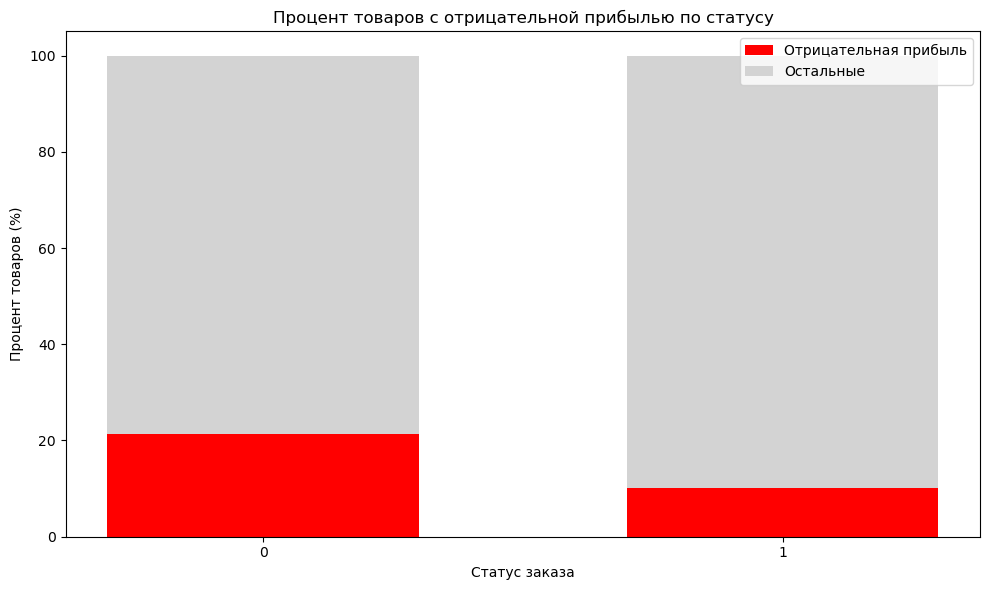

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.6
bar_positions = range(len(status_analysis['status']))

ax.bar(bar_positions, status_analysis['percent_negative_profit'], bar_width, label='Отрицательная прибыль', color='red')
ax.bar(bar_positions, status_analysis['percent_positive_profit'], bar_width, bottom=status_analysis['percent_negative_profit'], label='Остальные', color='lightgray')

ax.set_xlabel('Статус заказа')
ax.set_ylabel('Процент товаров (%)')
ax.set_title('Процент товаров с отрицательной прибылью по статусу')
ax.set_xticks(bar_positions)
ax.set_xticklabels(status_analysis['status'])
ax.legend()

plt.tight_layout()
plt.show()

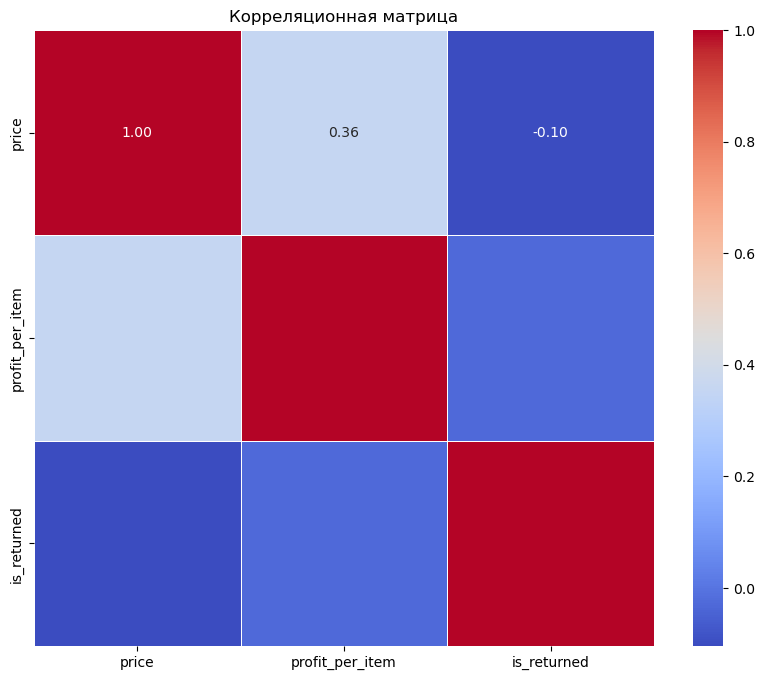

In [20]:
correlation_df = df[['price', 'profit_per_item']].copy()
correlation_df['is_returned'] = df['status'].apply(lambda x: 1 if x == 0 else 0)

correlation_matrix = correlation_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Корреляционная матрица')
plt.show()

Нет явной зависимости между ценой товара и его возвратом

## Анализ в зависимости от дня недели

In [21]:
df_filtered = df[df['status'] != 0].copy()
df_filtered.loc[:, 'total_profit'] = df_filtered['profit_per_item'] * df_filtered['count']

IsWeekend = df_filtered[df_filtered['is_weekend'] == True]
NotWeekend = df_filtered[df_filtered['is_weekend'] == False]

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


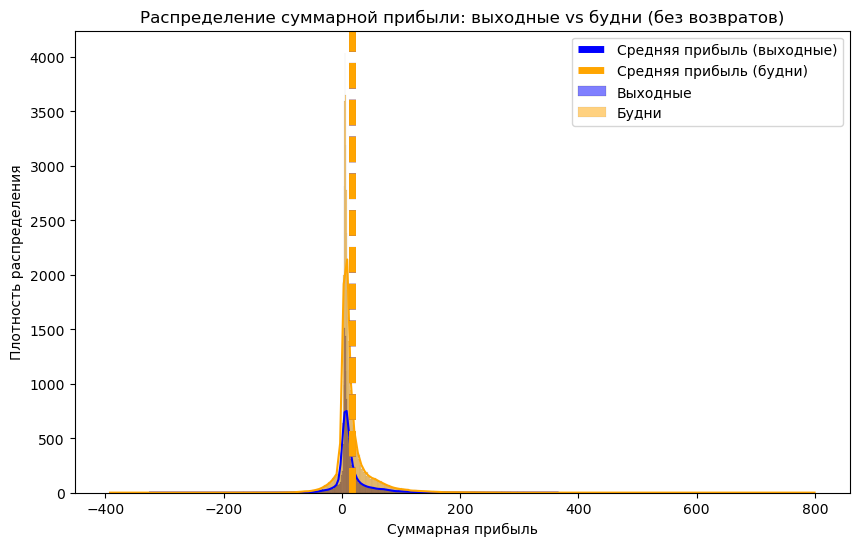

In [22]:
plt.figure(figsize=(10, 6))

ax1 = sns.histplot(IsWeekend['total_profit'], kde=True, label='Выходные', color='blue')
ax2 = sns.histplot(NotWeekend['total_profit'], kde=True, label='Будни', color='orange')

plt.axvline(np.mean(IsWeekend['total_profit']), color='blue', linestyle='dashed', linewidth=5, label='Средняя прибыль (выходные)')
plt.axvline(np.mean(NotWeekend['total_profit']), color='orange', linestyle='dashed', linewidth=5, label='Средняя прибыль (будни)')

plt.legend()

plt.xlabel('Суммарная прибыль')
plt.ylabel('Плотность распределения')
plt.title('Распределение суммарной прибыли: выходные vs будни (без возвратов)')

plt.show()

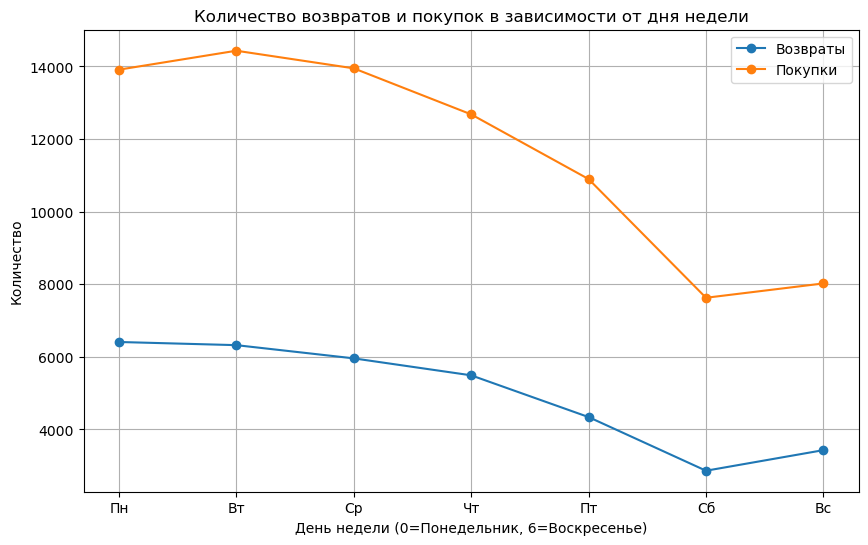

In [23]:
returns = df[df['status'] == 0].groupby('day_of_week').size()
purchases = df[df['status'] == 1].groupby('day_of_week').size()

plt.figure(figsize=(10, 6))
plt.plot(returns.index, returns.values, label='Возвраты', marker='o')
plt.plot(purchases.index, purchases.values, label='Покупки', marker='o')

plt.title('Количество возвратов и покупок в зависимости от дня недели')
plt.xlabel('День недели (0=Понедельник, 6=Воскресенье)')
plt.ylabel('Количество')
plt.xticks(ticks=range(7), labels=['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
plt.legend()
plt.grid(True)
plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


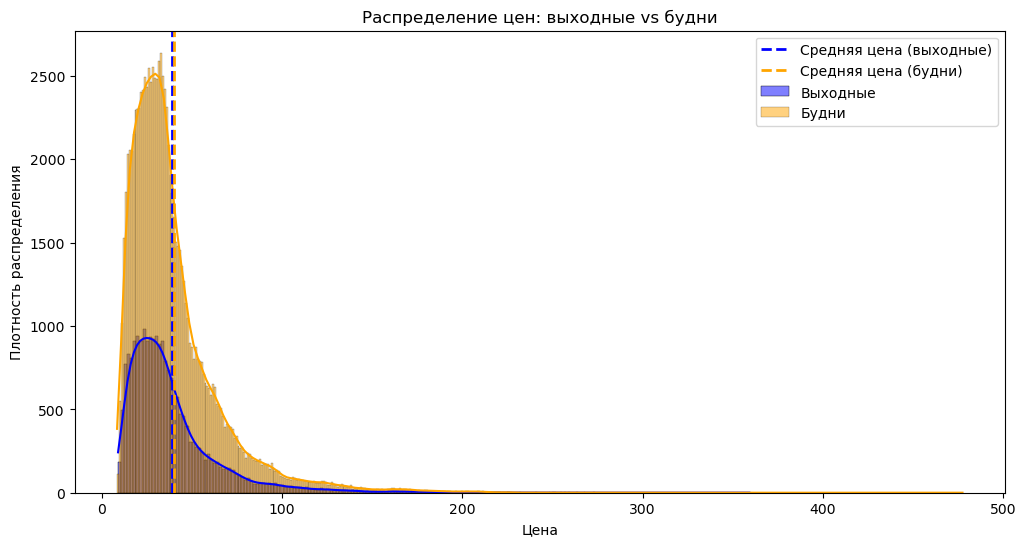

In [24]:
IsWeekend = df[df['is_weekend'] == True]
NotWeekend = df[df['is_weekend'] == False]

plt.figure(figsize=(12, 6))

sns.histplot(IsWeekend['price'], kde=True, color='blue', label='Выходные')

sns.histplot(NotWeekend['price'], kde=True, color='orange', label='Будни')

plt.axvline(np.mean(IsWeekend['price']), color='blue', linestyle='dashed', linewidth=2, label='Средняя цена (выходные)')
plt.axvline(np.mean(NotWeekend['price']), color='orange', linestyle='dashed', linewidth=2, label='Средняя цена (будни)')


plt.xlabel('Цена')
plt.ylabel('Плотность распределения')
plt.title('Распределение цен: выходные vs будни')

plt.legend()

plt.show()

Средняя цена в выходные и будние дни существенно не различается

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


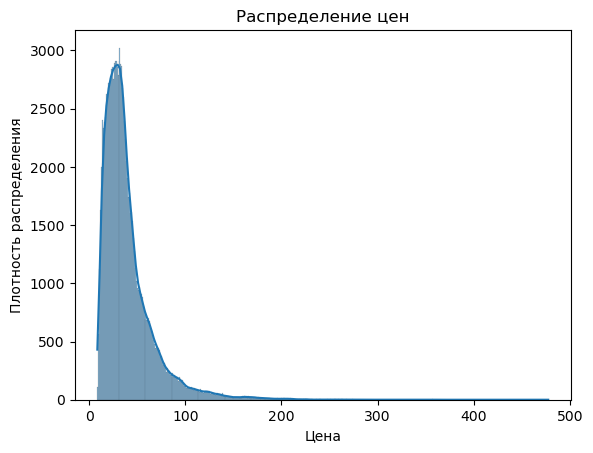

In [25]:
sns.histplot(df['price'], kde=True)

plt.xlabel('Цена')
plt.ylabel('Плотность распределения')
plt.title('Распределение цен')

plt.show()

## Анализ в зависимости от сезона

In [26]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Зима'
    elif month in [3, 4, 5]:
        return 'Весна'
    elif month in [6, 7, 8]:
        return 'Лето'
    elif month in [9, 10, 11]:
        return 'Осень'

df['season'] = df['month'].apply(get_season)

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

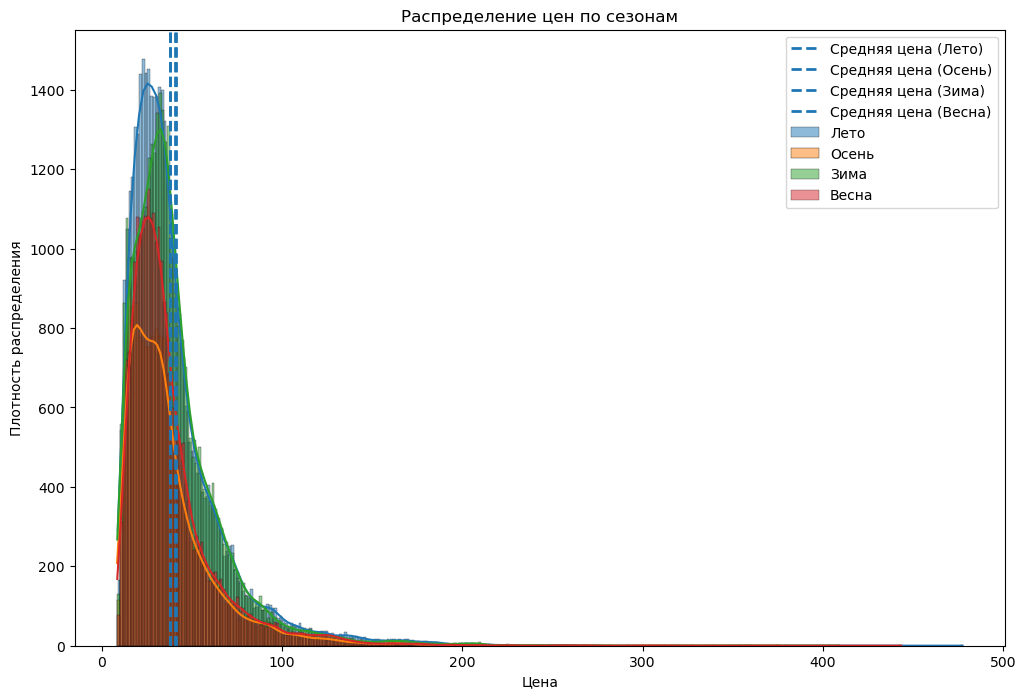

In [27]:
seasons = df['season'].unique()
plt.figure(figsize=(12, 8))
for season in seasons:
    subset = df[df['season'] == season]
    sns.histplot(subset['price'], kde=True, label=season)

for season in seasons:
    subset = df[df['season'] == season]
    plt.axvline(np.mean(subset['price']), linestyle='dashed', linewidth=2, label=f'Средняя цена ({season})')
    
plt.xlabel('Цена')
plt.ylabel('Плотность распределения')
plt.title('Распределение цен по сезонам')

plt.legend()
plt.show()

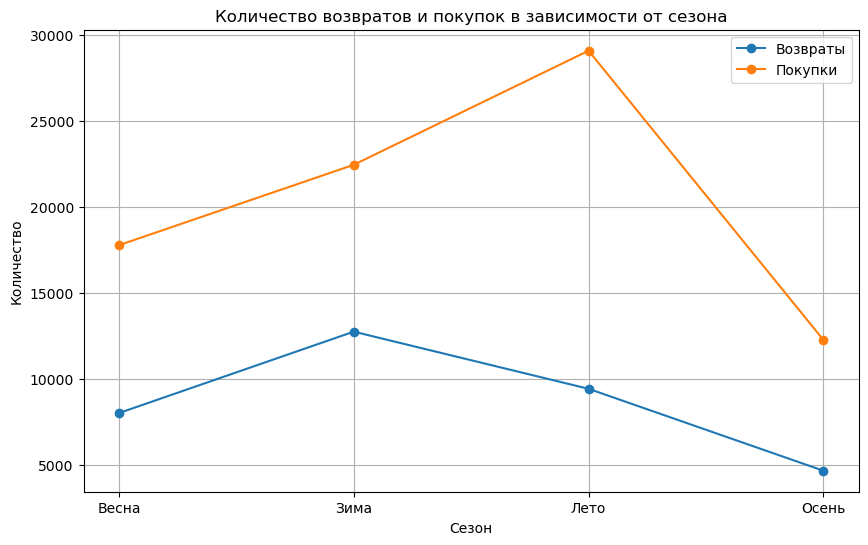

In [28]:
returns = df[df['status'] == 0].groupby('season').size()
purchases = df[df['status'] == 1].groupby('season').size()

plt.figure(figsize=(10, 6))
plt.plot(returns.index, returns.values, label='Возвраты', marker='o')
plt.plot(purchases.index, purchases.values, label='Покупки', marker='o')

plt.title('Количество возвратов и покупок в зависимости от сезона')
plt.xlabel('Сезон')
plt.ylabel('Количество')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
df['date_confirm'] = pd.to_datetime(df['date_confirm'])
df.set_index('date_confirm', inplace=True)

Месяц с максимальным количеством продаж: 2024-01-31
Количество продаж в этом месяце: 20747.00


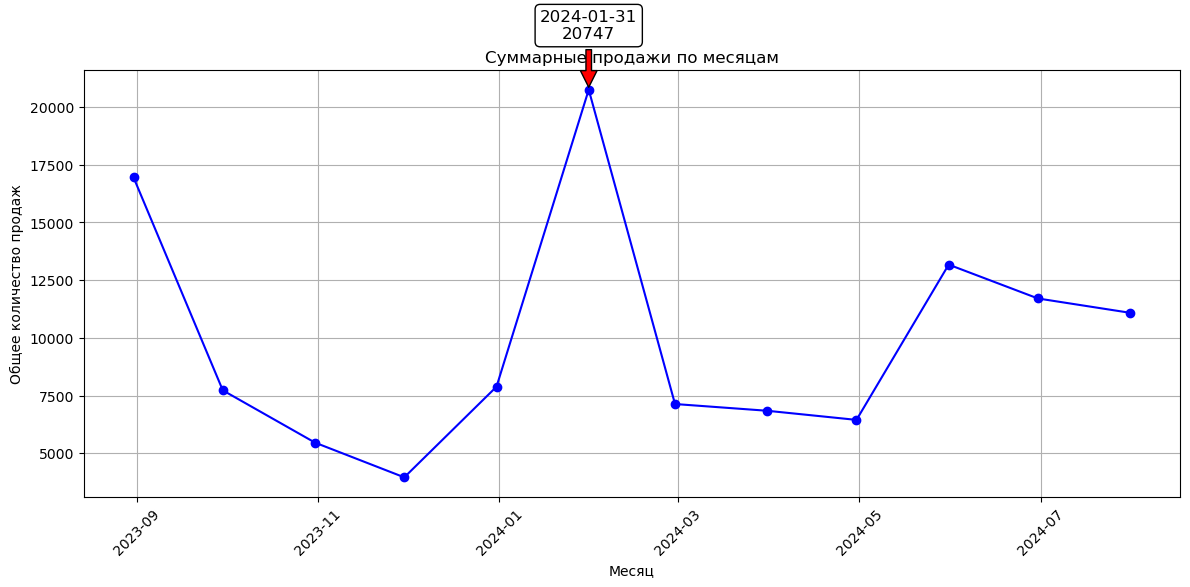

In [30]:
monthly_sales = df.resample('M').agg({'count': 'sum'})

plt.figure(figsize=(12, 6))
plt.plot(monthly_sales.index, monthly_sales['count'], marker='o', linestyle='-', color='b')

plt.title('Суммарные продажи по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Общее количество продаж')
plt.grid(True)
plt.xticks(rotation=45)

max_sales_month = monthly_sales['count'].idxmax()
max_sales_value = monthly_sales['count'].max()

print(f"Месяц с максимальным количеством продаж: {max_sales_month.strftime('%Y-%m-%d')}")
print(f"Количество продаж в этом месяце: {max_sales_value:.2f}")

plt.annotate(
    f'{max_sales_month.strftime("%Y-%m-%d")}\n{max_sales_value}',
    xy=(max_sales_month, max_sales_value),
    xytext=(max_sales_month, max_sales_value + (0.1 * max_sales_value)),  # Позиция текста выше точки
    ha='center',
    va='bottom',
    bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'),
    arrowprops=dict(facecolor='red', shrink=0.05),
    fontsize=12,
    color='black'
)

plt.tight_layout()
plt.show()


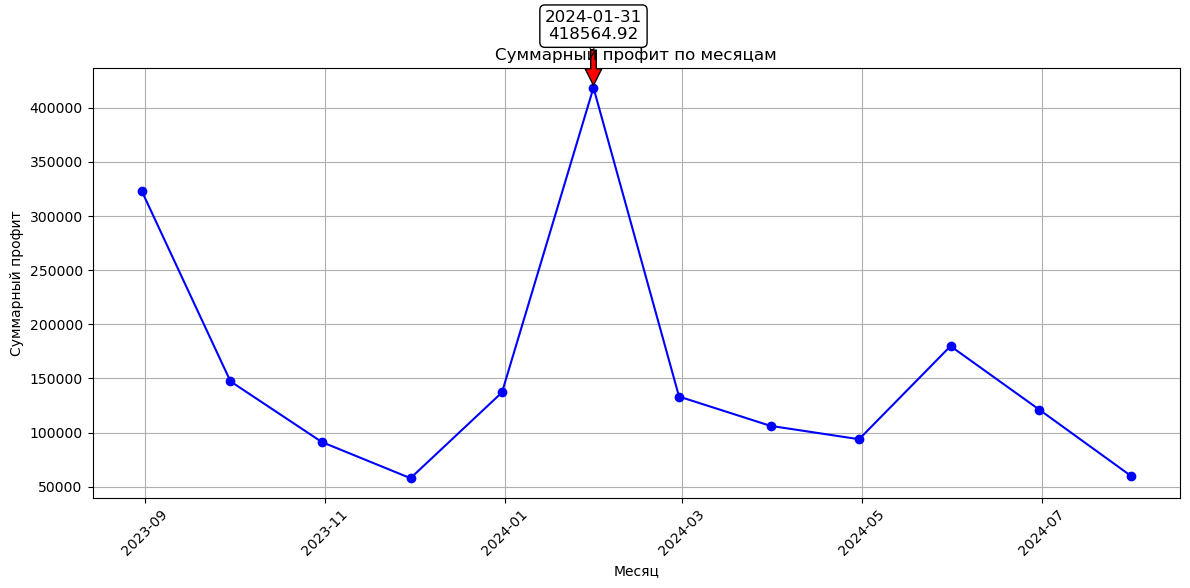

In [31]:
monthly_sales = df.resample('M').agg({'profit_per_item': 'sum'})
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales.index, monthly_sales['profit_per_item'], marker='o', linestyle='-', color='b')

plt.title('Суммарный профит по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Суммарный профит')
plt.grid(True)
plt.xticks(rotation=45)

max_sales_value = monthly_sales['profit_per_item'].max()
max_sales_month = monthly_sales['profit_per_item'].idxmax()


plt.annotate(
    f'{max_sales_month.strftime("%Y-%m-%d")}\n{max_sales_value}',
    xy=(max_sales_month, max_sales_value),
    xytext=(max_sales_month, max_sales_value + (0.1 * max_sales_value)),  # Позиция текста выше точки
    ha='center',
    va='bottom',
    bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'),
    arrowprops=dict(facecolor='red', shrink=0.05),
    fontsize=12,
    color='black'
)

plt.tight_layout()
plt.show()

## Анализ товаров

In [32]:
most_profitable = profit_by_product.sort_values(by='total_profit', ascending=False).head(5)
least_profitable = profit_by_product.sort_values(by='total_profit').head(5)

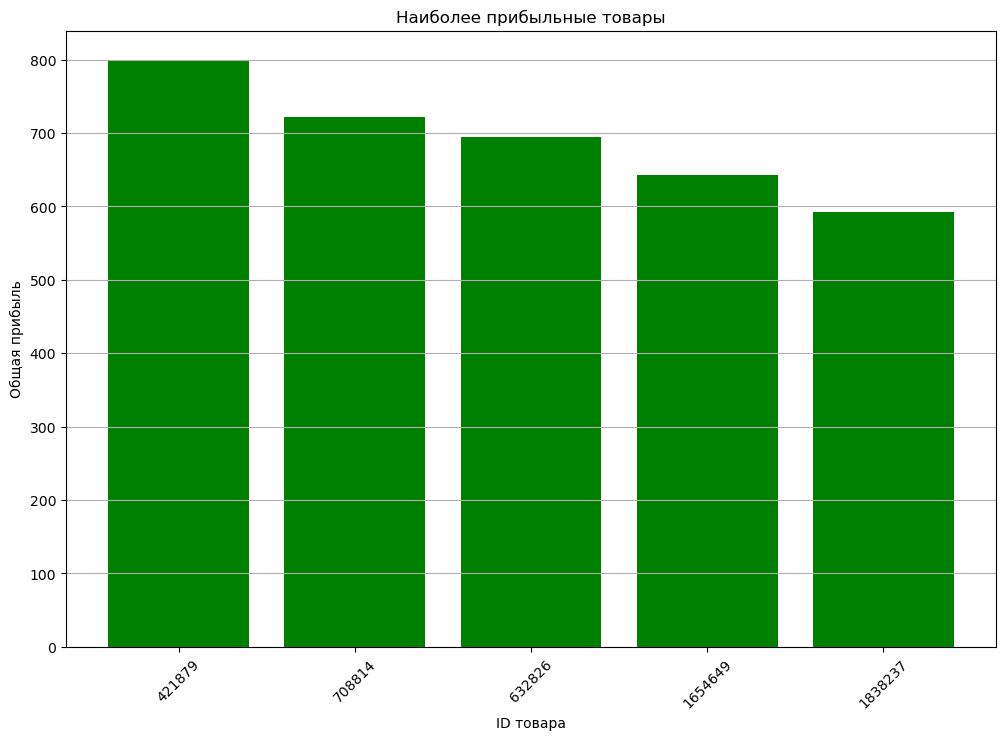

In [33]:
plt.figure(figsize=(12, 8))
plt.bar(most_profitable.astype(str)['product_id'], most_profitable['total_profit'], color='green')  # Зеленый цвет для Shipped
plt.title('Наиболее прибыльные товары')
plt.xlabel('ID товара')
plt.ylabel('Общая прибыль')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


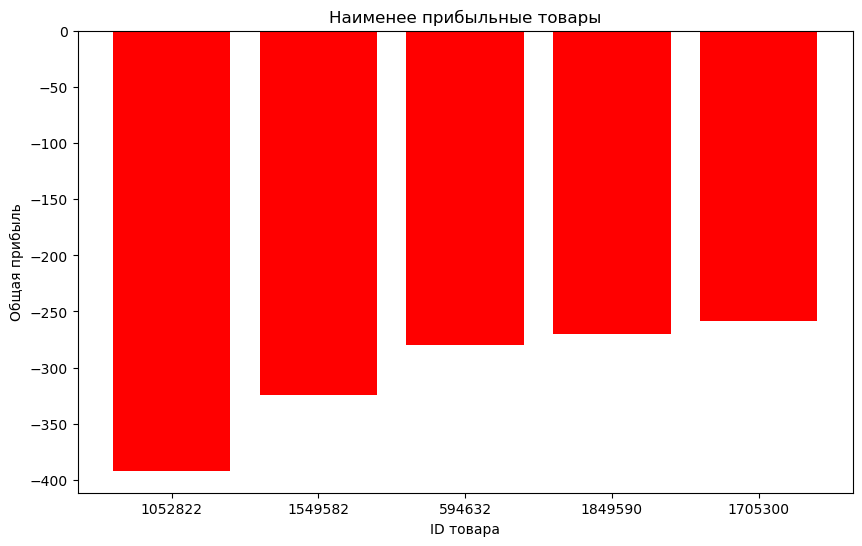

In [34]:
plt.figure(figsize=(10, 6))
plt.bar(least_profitable.astype(str)['product_id'], least_profitable['total_profit'], color='red')
plt.title('Наименее прибыльные товары')
plt.xlabel('ID товара')
plt.ylabel('Общая прибыль')
plt.show()

## Продукты, которые были проданы в наибольшем количестве

In [35]:
sales_by_product = df[df['status'] == 1].groupby('product_id').agg({'count': 'sum', 'price': 'mean'}).reset_index()
sales_by_product.rename(columns={'count': 'count_sold'}, inplace=True)
sales_by_product.sort_values(by='count_sold', ascending=False).head(5)

,product_id,count_sold,price
3349,90587,30,12.91
51245,1330807,20,14.06
22984,634096,19,12.81
72496,1838237,16,130.95
28399,766553,16,58.68


## Анализ аренды

In [36]:
rental_sales = df.groupby('is_rental')['count'].sum()
rental_returns = df[df['status'] == 0].groupby('is_rental')['count'].sum()

print("Продажи по типу аренды:")
print(rental_sales)
print("Возвраты по типу аренды:")
print(rental_returns)


Продажи по типу аренды:
is_rental
0    70459
1    48648
Name: count, dtype: int64
Возвраты по типу аренды:
is_rental
0      917
1    33905
Name: count, dtype: int64


In [37]:
rental_data = df.groupby('is_rental').agg({
    'count': 'sum',
    'status': lambda x: (x == 0).sum()
}).rename(columns={'status': 'count_returned'})

rental_data['return_rate'] = (rental_data['count_returned'] / rental_data['count']) * 100

print("Процент возвратов по типу аренды:")
print(rental_data[['return_rate']])


Процент возвратов по типу аренды:
           return_rate
is_rental             
0             1.300047
1            69.694540


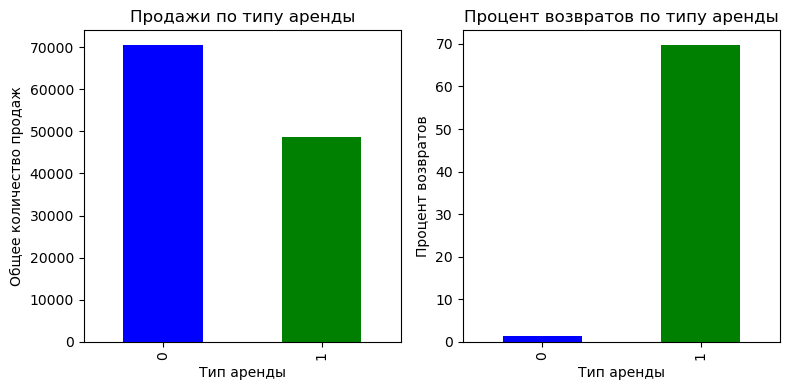

In [38]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
rental_sales.plot(kind='bar', color=['blue', 'green'])
plt.title('Продажи по типу аренды')
plt.xlabel('Тип аренды')
plt.ylabel('Общее количество продаж')


plt.subplot(1, 2, 2)
rental_data['return_rate'].plot(kind='bar', color=['blue', 'green'])
plt.title('Процент возвратов по типу аренды')
plt.xlabel('Тип аренды')
plt.ylabel('Процент возвратов')

plt.tight_layout()
plt.show()


In [39]:
customer_returns = df[df['status'] == 0].groupby('order_id').agg({'count': 'sum'}).reset_index()
customer_total = df.groupby('order_id').agg({'count': 'sum'}).reset_index()
customer_stats = pd.merge(customer_total, customer_returns, on='order_id', how='left', suffixes=('_total', '_returned'))
customer_stats['count_returned'].fillna(0, inplace=True)
customer_stats['return_rate'] = (customer_stats['count_returned'] / customer_stats['count_total']) * 100

print("Средний процент возвратов по клиентам:")
print(customer_stats['return_rate'].mean())

Средний процент возвратов по клиентам:
29.91632969093303


In [40]:
returned_products = df[df['status'] == 0]
shipped_products = df[df['status'] == 1]

average_price_returned = returned_products['price'].mean()
average_price_shipped = shipped_products['price'].mean()

print(f"Средняя цена для возвращенных товаров: {average_price_returned:.2f}")
print(f"Средняя цена для доставленных товаров: {average_price_shipped:.2f}")


Средняя цена для возвращенных товаров: 35.47
Средняя цена для доставленных товаров: 41.59


# sarima

In [41]:

df = pd.read_csv('dataset - dataset.csv')
df['date_confirm'] = pd.to_datetime(df['date_confirm'])

df_daily = df.groupby('date_confirm').agg({'count': 'sum'}).reset_index()
df_daily.set_index('date_confirm', inplace=True)
df_daily.sort_index(inplace=True)


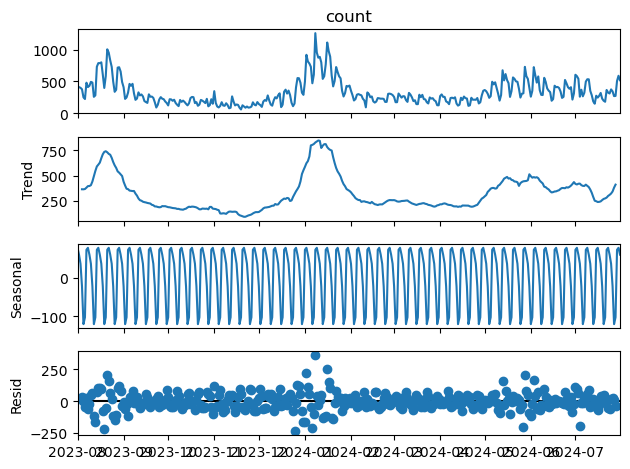

In [42]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df_daily['count'], model='additive')
result.plot()
plt.show()


In [43]:

df.set_index('date_confirm', inplace=True)
df_daily = df.resample('D').agg({'profit_per_item': 'sum'})
df_daily = df_daily.rename(columns={'profit_per_item': 'daily_profit'})
data = df_daily['daily_profit']

In [44]:
# Проведение теста Дики-Фуллера
result = adfuller(data)

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

if result[1] <= 0.05:
    print("Ряд стационарен")
else:
    print("Ряд нестационарен")


ADF Statistic: -3.7537748768036425
p-value: 0.003417291272752837
Critical Values: {'1%': -3.44911857009962, '5%': -2.8698097654570507, '10%': -2.5711757061225153}
Ряд стационарен


In [45]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(data, 
                 order=(1, 1, 0), 
                 seasonal_order=(1, 1, 0, 7))
results = model.fit()

print(results.summary())


                                     SARIMAX Results                                     
Dep. Variable:                      daily_profit   No. Observations:                  366
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 7)   Log Likelihood               -3213.910
Date:                           Mon, 26 Aug 2024   AIC                           6433.821
Time:                                   22:31:22   BIC                           6445.463
Sample:                               08-01-2023   HQIC                          6438.451
                                    - 07-31-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2664      0.023    -11.534      0.000      -0.312      -0.221
ar.S.L7       -0.4697      0.024    -19.408

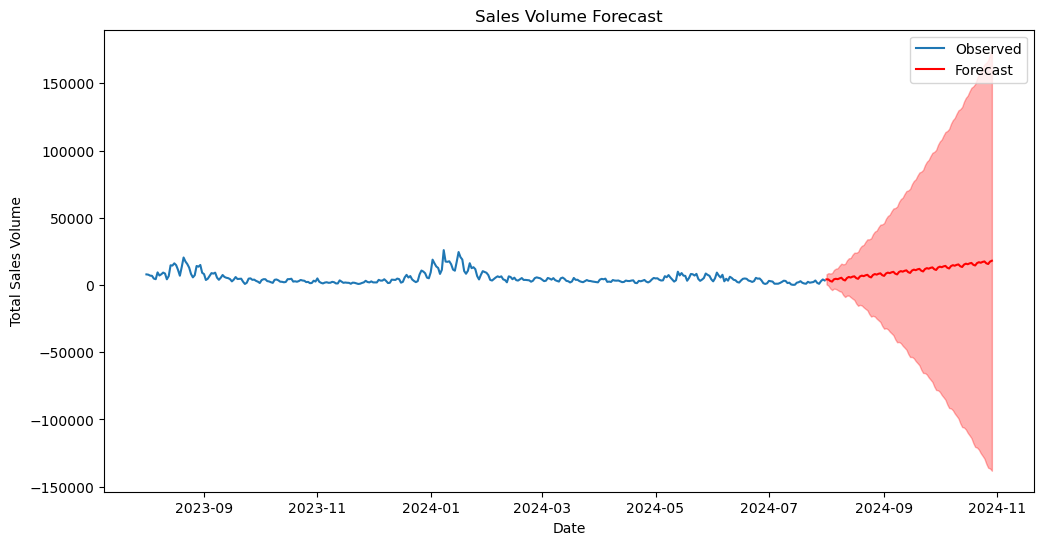

In [46]:
forecast = results.get_forecast(steps=90)
forecast_index = pd.date_range(start=df_daily.index[-1] + pd.Timedelta(days=1), periods=90, freq='D')

forecast_conf_int = forecast.conf_int()
forecast_df = pd.DataFrame({
    'forecast': forecast.predicted_mean,
    'lower_conf_int': forecast_conf_int['lower daily_profit'],
    'upper_conf_int': forecast_conf_int['upper daily_profit']
}, index=forecast_index)

plt.figure(figsize=(12, 6))
plt.plot(df_daily.index, data, label='Observed')
plt.plot(forecast_df.index, forecast_df['forecast'], label='Forecast', color='red')
plt.fill_between(forecast_df.index, 
                 forecast_df['lower_conf_int'], 
                 forecast_df['upper_conf_int'], 
                 color='red', alpha=0.3)
plt.title('Sales Volume Forecast')
plt.xlabel('Date')
plt.ylabel('Total Sales Volume')
plt.legend()
plt.show()

In [47]:
forecast_df

,forecast,lower_conf_int,upper_conf_int
2024-08-01,4201.635952,453.251371,7950.020532
2024-08-02,4173.747511,-475.211618,8822.706639
2024-08-03,3008.949494,-2532.581230,8550.480218
2024-08-04,2538.311149,-3737.203442,8813.825740
2024-08-05,4233.685933,-2706.565061,11173.936927
...,...,...,...
2024-10-25,17525.923783,-129165.326575,164217.174142
2024-10-26,16169.447702,-132961.367115,165300.262518
2024-10-27,15624.371000,-135898.201443,167146.943443
2024-10-28,17394.898099,-136484.498136,171274.294335
